**Algorytm KNN**

W najprostszej wersji algorytm KNN jest algorytmem klasyfikującym. Klasyfikacja obiektu polega na znalezieniu $K$ najbliższych sąsiadów względem wybranej przez nas metryki oraz wybraniu najliczniejszej klasy spośród tych sąsiadów.

Algorytm KNN może też być stosowany w wersji regresyjnej. W tej wersji obiektowi przypisujemy wartość, która jest średnią wartości $K$ najbliższych sąsiadów.

**Teoretyczne ograniczenia algorytmu KNN**

$C_1, \ldots, C_M$ - klasy, do których chcemy przypisywać obiekty.

$X$ - rodzina obiektów, które chcemy klasyfikować.

W teoretycznych rozważaniach przyjmuje się, że każdy obiekt ma zadany 'prawdziwy' rozkład prawdopodobieństw ($\hat{P}(C_i | x)$ dla $x \in X$) przynależności do klas.
Zadaniem klasyfikatorów jest tak naprawdę aproksymacja tych rozkładów.

Przez **błąd** klasyfikatora na obiekcie $x$ rozumiemy prawdopodobieństwo przypisania $x$ do niepoprawnej klasy
$$\texttt{Err}_x = \sum_{i = 1}^{M} (C_i \neq \tilde{C}(x))\hat{P}(C_i|x),$$
gdzie $\tilde{C}(x)$ to klasa, którą nasz klasyfikator przypisuje do $x$.

Przez **współczynnik błędu** klasyfikatora rozumiemy oczekiwaną wartość błędu, gdy obiekt $x$ jest losowo wybrany z rodziny $X$. Niekoniecznie musi się to dziać z jednostajnym prawdopodobieństwem, ale na potrzeby naszych rozważań przyjmujemy takie założenie.
$$\texttt{Err} = E[\texttt{Err}_x].$$

Przez **Bayesowski współczynnik błędu** rozumiemy najniższy możliwy współczynnik błędu. Jest on równy współczynnikowi błędu 'idealnego' klasyfikatora, który zna prawdziwe rozkłady $\hat{P}(C_i | x)$ i każdy element po prostu przypisuje do najbardziej prawdopodobnej klasy.

W takiej sytuacji błąd na obiekcie $x$ upraszcza się do
$$\texttt{Err}_x = 1 - \max_i \hat{P}(C_i | x),$$

a więc Bayesowski współczynnik błędu wyrażony jest przez
$$B^* = E_x\bigg[1 - \max_i \hat{P}(C_i | x)\bigg].$$

Po dokonaniu kilku zdroworozsądkowych założeń można udowodnić, że błąd klasyfikatora KNN jest co najwyżej dwa razy większy niż błąd Bayesowski.

Dokładniejsze ograniczenie wynosi
$$B_{kNN} \leq B^*\bigg(2 - \frac{M B^*}{M - 1}\bigg).$$

**Złożoność obliczeniowa**

$T$ - rozmiar zbioru treningowego

$S$ - rozmiar zbioru testowego

$K$ - parametr KNN

W naiwnej implementacji KNN porównujemy odległości obiektów $T \cdot S \cdot K$ razy. To dużo.

Można tą ilość łatwo zmniejszyć wykorzystując *kopiec* (struktura danych) do $T \cdot S \cdot \log K$.

Czynnik $T \cdot S$ można zmniejszyć wykorzystując zoptymalizowane struktury danych do przeszukiwania przestrzeni (np. $kd$-drzewa), jednak one zazwyczaj radzą sobie dobrze tylko w niewielkiej liczbie wymiarów.

W praktyce, na naprawdę dużych zbiorach danych, stosuje się zazwyczaj algorytmy aproksymujące, które minimalnie zmniejszają zgodność klasyfikacji z oryginalną ideą algorytmu w zamian za znaczne zmniejszenie wymaganej liczby porównań.

**Wybór metryki**

- Euklidesowa

$$d(x, y) = \sqrt{\sum_{i = 1}^n (x_i - y_i)^2}$$

- Manhattan

$$d(x, y) = \sum_{i = 1}^n |x_i - y_i|$$

- Cosinusowa

$$\text{cossimilarity}(x, y) = \frac{x \cdot y}{ ||x|| \cdot ||y|| } $$

- Hamminga
$$H(x, y) = \sum_{i = 1}^n x_i \neq y_i.$$

**Ważony KNN**

Algorytm KNN można bardzo prosto uogólnić przypisując sąsiadom różne *wagi* na etapie wyboru najliczniejszej klasy. W najprostszej wersji algorytmu wszystkim sąsiadom przypisujemy stałą wagę $\frac{1}{K}$.

$d_i$ - dystans $i$-tego sąsiada od aktualnie rozpatrywanego obiektu 

W *ważonej* wersji KNN każdemu sąsiadowi przypisujemy wagę proporcjonalną do jego dystansu od rozpatrywanego obiektu
$$\frac{\frac{1}{d_i}}{\sum_{i = 1}^{K} \frac{1}{d_i}}.$$

In [1]:
# imports
from typing import Literal
import requests
import gzip
import numpy as np
import io
import struct
import matplotlib.pyplot as plt

In [2]:
def _download_and_decompress(url):
    print(f"Downloading {url}...")
    response = requests.get(url)
    with gzip.GzipFile(fileobj=io.BytesIO(response.content)) as f:
        return f.read()

def _read_images_from_bytes(data):
    _, num_images, rows, cols = struct.unpack(">IIII", data[:16])
    images = np.frombuffer(data[16:], dtype=np.uint8)
    images = images.reshape(num_images, rows, cols)
    return images

def _read_labels_from_bytes(data):
    labels = np.frombuffer(data[8:], dtype=np.uint8)
    return labels

def _parse_raw_data(url, func):
    raw_data = _download_and_decompress(url)
    return func(raw_data)

def download_set(kind: Literal["train", "test"]):
    if kind == "test":
        kind = "t10k" # Great naming.
    url_images = f"https://storage.googleapis.com/cvdf-datasets/mnist/{kind}-images-idx3-ubyte.gz"
    url_labels = f"https://storage.googleapis.com/cvdf-datasets/mnist/{kind}-labels-idx1-ubyte.gz"

    return _parse_raw_data(url_images, _read_images_from_bytes), _parse_raw_data(url_labels, _read_labels_from_bytes)

In [3]:
train_data, train_labels = download_set("train")
train_data, train_labels = train_data[:1000], train_labels[:1000]
test_data, test_labels = download_set("test")
test_data, test_labels = test_data[:200], test_labels[:200]

# **W rozwiązaniach zadań 1-7 nie wolno importować nowych bibliotek!**

**Zadanie 1.**

Narysuj (na gridzie 2x5) po jednym przykładzie każdej z cyfr z danych treningowych.

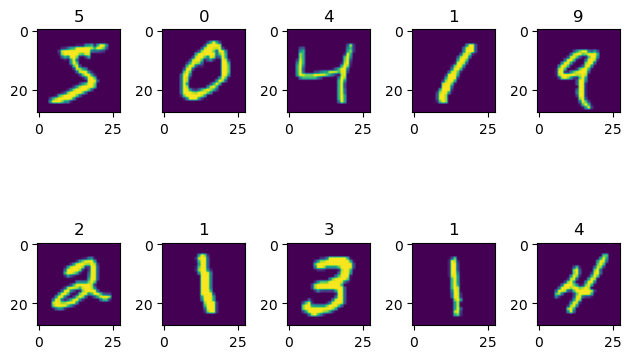

In [4]:
fig, ax = plt.subplots(2, 5)
for itr in np.ndindex(ax.shape):
    ax[itr].imshow(train_data[itr[0]*5 + itr[1]], cmap='viridis')
    ax[itr].set(title = f"{train_labels[itr[0]*5 + itr[1]]}")
fig.tight_layout()

**Zadanie 2.**

Zaimplementuj klasę `KNNClassifier`, która w konstruktorze przyjmuje treningowe obrazki, ich etykiety oraz parametr $K$.

Klasa ta powinna mieć funkcję `classify`, która przyjmuje obrazek ze zbioru testowego, znajduje $K$ najbliższych sąsiadów i zwraca najbardziej popularną etykietę spośród tych sąsiadów. W przypadku remisów może zwracać dowolną najpopularniejszą etykietę.

Możesz użyć dowolnej metryki spośród tych wymienionych w części teoretycznej.

Pamiętaj, że obrazki są dwuwymiarowymi tablicami.

In [5]:
def get_mode(seq: np.ndarray):
    values, counts = np.unique(seq, return_counts=True)
    return values[np.argmax(counts)]


class KNNNClassifier:
    def __init__(self, train_data, train_labels, K):
        self.train_data, self.train_labels = train_data.reshape(train_data.shape[0], -1), train_labels
        self.K = K
        train_data_mean = np.mean(self.train_data, axis=1)[:, np.newaxis]
        train_data_std = np.std(self.train_data, axis=1)[:, np.newaxis] 
        self.train_data = self.train_data - train_data_mean
        self.train_data = self.train_data / train_data_std
    
    def classify(self, picture):
        picture = picture.reshape(-1)
        picture = picture - np.mean(picture)
        picture = picture / np.std(picture)
        distances = np.linalg.norm(self.train_data - picture, axis = 1)
        nearest_indices = distances.argsort()[:self.K]
        nearest_labels = self.train_labels[nearest_indices]
        return get_mode(nearest_labels)
        
        

**Zadanie 3.**

Stwórz instancję `KNNClassifier` z danymi treningowymi dla `K` równego 3. Dokonaj klasyfikacji zbioru testowego i oblicz accuracy.

In [6]:
KNN_instance = KNNNClassifier(train_data=train_data, train_labels=train_labels, K=3)
KNN_predict = KNN_instance.classify
results_test = list(map(KNN_predict, test_data))
correct_predictions = [i for i in range(len(test_data)) if results_test[i] == test_labels[i]]
print(len(correct_predictions) / len(test_data))

0.875


**Zadanie 4.**

Powtórz eksperyment dla `K` z zakresu 1 do 20. Narysuj wykres jak się zmienia accuracy w zależności od $K$.

20
5


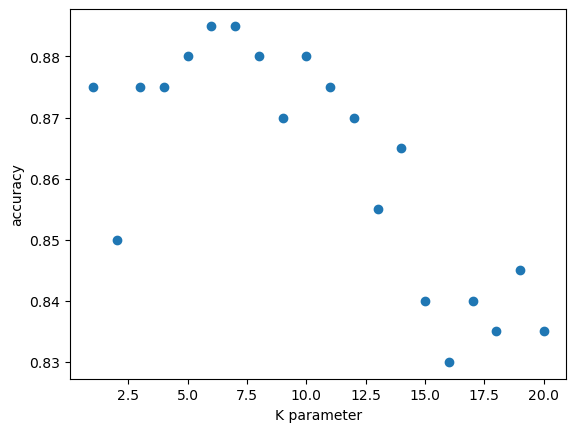

In [11]:
accuracy = np.zeros(shape=20, dtype=float)
for itr in range(1, 21):
    KNN_instance = KNNNClassifier(train_data=train_data, train_labels=train_labels, K=itr)
    KNN_predict = KNN_instance.classify
    results_test = list(map(KNN_predict, test_data))
    correct_predictions = [i for i in range(len(test_data)) if results_test[i] == test_labels[i]]
    accuracy[itr - 1] = len(correct_predictions) / len(test_data)

x_axis = np.arange(start=1, stop=21, step=1)
print(len(x_axis))
fig, ax = plt.subplots()
ax.scatter(x_axis, accuracy)
ax.set(xlabel='K parameter', ylabel='accuracy')

print(np.argmax(accuracy))

**Zadanie 5.**

Odczytaj z wykresu optymalne `K` względem accuracy. Wybierz 20 losowych obrazków, dla których Twój klasyfikator się pomylił. Narysuj je (jako grid 4x5) i podpisz poprawną etykietą oraz tą wskazaną przez klasyfikator.

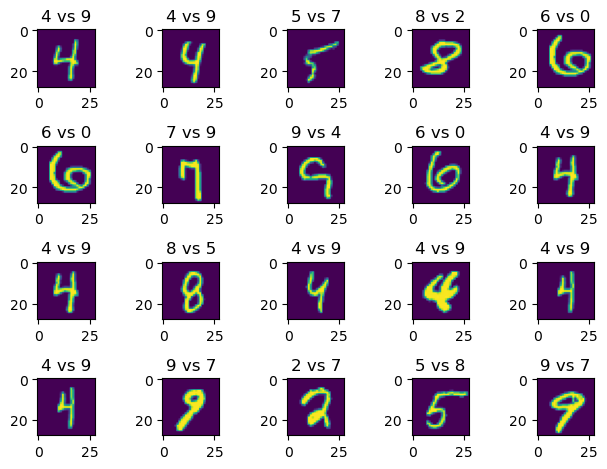

In [14]:
KNN_optimal = KNNNClassifier(train_data=train_data, train_labels=train_labels, K=5)
KNN_optimal_predict = KNN_optimal.classify
incorrect_predictions = [ind for ind in range(len(test_data)) if KNN_optimal_predict(test_data[ind]) != test_labels[ind]]
sample = np.random.choice(incorrect_predictions, size=20, replace=False)

fig, ax = plt.subplots(4,5)
for itr in np.ndindex(ax.shape):
    ax[itr].imshow(test_data[sample[itr[0] * 4 + itr[1]]])
    ax[itr].set(title = f'{test_labels[sample[itr[0] * 4 + itr[1]]]} vs {KNN_optimal_predict(test_data[sample[itr[0] * 4 + itr[1]]])}')
fig.tight_layout()

**Zadanie 6.**

Zaimplementuj klasę `WeightedKNNClassifier`, która działa analogicznie do klasy `KNNClassifier`, ale implementuje *ważoną* wersję algorytmu KNN.

In [16]:
class WeightedKNNClassifier(KNNNClassifier):
    def __init__(self, train_data, train_labels, K):
        super().__init__(train_data, train_labels, K)
    def classify(self, picture):
        picture = picture.reshape(-1)
        picture = picture - np.mean(picture)
        picture = picture / np.std(picture)
        picture = picture[np.newaxis, :]
        distances = np.linalg.norm(self.train_data - picture, axis=1)
        nearest_indices = np.argsort(distances)[:self.K]
        vote = np.zeros(shape=10)
        weight_sum = 0
        for i in nearest_indices:
            label = self.train_labels[i]
            weight = 1 / distances[i]
            weight_sum += weight
            vote[label] += weight
        vote = vote / weight_sum
        return np.argmax(vote)
        
        

**Zadanie 7.**

Nanieś accuracy zwykłego oraz ważonego klasyfikatora KNN dla $K$ z przediału od 1 do 20 i oceń, który z tych klasyfikatorów sprawdził się lepiej dla tych danych.

In [43]:
accuracy = np.zeros(shape=20, dtype=float)
accuracy_weighted = np.zeros(shape=20, dtype=float)
for itr in range(1, 21):
    KNN_instance = KNNNClassifier(train_data=train_data, train_labels=train_labels, K=itr)
    KNN_predict = KNN_instance.classify
    
    KNN_weighted = WeightedKNNClassifier(train_data, train_labels, K=itr)
    weighted_predict = KNN_weighted.classify
    
    predictions = list(map(KNN_predict, test_data))
    correct_predictions = [i for i in range(len(test_data)) if predictions[i] == test_labels[i]]
    accuracy[itr - 1] = len(correct_predictions) / len(test_data)
    
    predictions_weighted = list(map(weighted_predict, test_data))
    correct_weighted = [i for i in range(len(test_data)) if predictions_weighted[i] == test_labels[i]]
    accuracy_weighted[itr - 1] = len(correct_weighted) / len(test_data)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[0.885, 6]
[0.895, 6]


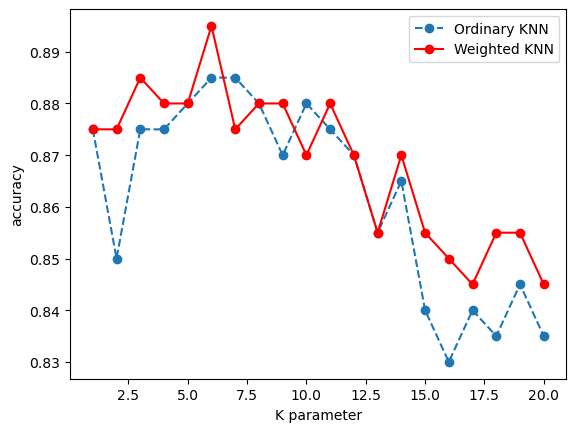

In [49]:
x_axis = np.arange(start=1, stop=21, step=1)
print(x_axis)
fig, ax = plt.subplots()
ax.plot(x_axis, accuracy, marker = 'o', label="Ordinary KNN", linestyle="--")
ax.plot(x_axis, accuracy_weighted, marker='o', linestyle=None, color='r', label='Weighted KNN')
ax.set(xlabel='K parameter', ylabel='accuracy')
ax.legend()

print([np.max(accuracy), np.argmax(accuracy) + 1])
print([np.max(accuracy_weighted), np.argmax(accuracy_weighted) + 1])

In [40]:
from sklearn.neighbors import KNeighborsClassifier
x_train_flat = train_data.reshape(train_data.shape[0], -1)
y_train = train_labels

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train_flat, y_train)

y_pred = knn.predict(test_data.reshape(test_data.shape[0], -1)[0:20, :])
print(knn.score(test_data.reshape(test_data.shape[0], -1), test_labels))
print(list(zip(y_pred, test_labels[0:20])))

0.855
[(7, 7), (2, 2), (1, 1), (0, 0), (4, 4), (1, 1), (9, 4), (9, 9), (4, 5), (7, 9), (0, 0), (6, 6), (9, 9), (0, 0), (1, 1), (3, 5), (9, 9), (7, 7), (2, 3), (9, 4)]


**Zadanie 8.**

Wykorzystaj bibliotekę `scikit-learn` do znalezienia najlepszych hiperparametrów dla algorytmu KNN na zbiorze danych 'iris' wykorzystując podejście grid search.

Sprawdź następujące zbiory hiperparametrów:
- $K \in [1, 20]$,
- algorytm KNN zwykły albo ważony,
- metryka euklidesowa lub Manhattan.

Zbiór danych podziel na zbiór treningowy i testowy w proporcji 1:1.

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier as knn



iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

model = knn()

param_grid = {
    'n_neighbors': range(1,21),
    'metric': ['euclidean', 'manhattan'],
    'weights': ['uniform', 'distance'],
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

best_model = grid_search.best_estimator_
accuracy = best_model.score(X_test, y_test)
print(accuracy)



{'metric': 'euclidean', 'n_neighbors': 8, 'weights': 'uniform'}
0.9466666666666667
0.9466666666666667


In [144]:
a = np.random.randint(low=0, high=10, size=(3,4,2))
print(a[0].shape)
print(a[0][0].shape)
print(a[[0,1]][:,[0,1]].shape)


(4, 2)
(2,)
(2, 2, 2)
